In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import datetime, timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import shutil



Define Variables

In [2]:
start_date = '2024-03-20'
end_date = '2024-03-21'

Fetch data and store as dataframe

In [3]:
data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date, end_date))
data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date, end_date))
df = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date)
print(f' Head of dataframe: \n',df.head())
print(f' \n Shape of df', df.shape)
print(f'\nTypes for each column: \n', df.dtypes)
print(f'This is the time index for na records:\n',df[df.isna().any(axis=1)])

File not found: /Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/DUMMY/2024-03-21.ctumag
File not found: /Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/DUMMY/2024-03-21.squid
 Head of dataframe: 
                          NS_SQUID  F_SQUID  NS_Fluxgate  EW_Fluxgate  \
Time                                                                   
2024-03-21 15:15:10.540  -17.2443   0.3012   10934.2807     -42.4087   
2024-03-21 15:15:10.740  -17.2414   0.3024   10934.2699     -42.4171   
2024-03-21 15:15:10.940  -17.2352   0.2902   10934.2699     -42.4171   
2024-03-21 15:15:11.140  -17.2389   0.2985   10934.2653     -42.4182   
2024-03-21 15:15:11.340  -17.2338   0.2598   10934.2594     -42.3772   

                         Z_Fluxgate  
Time                                 
2024-03-21 15:15:10.540 -22656.4241  
2024-03-21 15:15:10.740 -22656.4286  
2024-03-21 15:

PLot the data

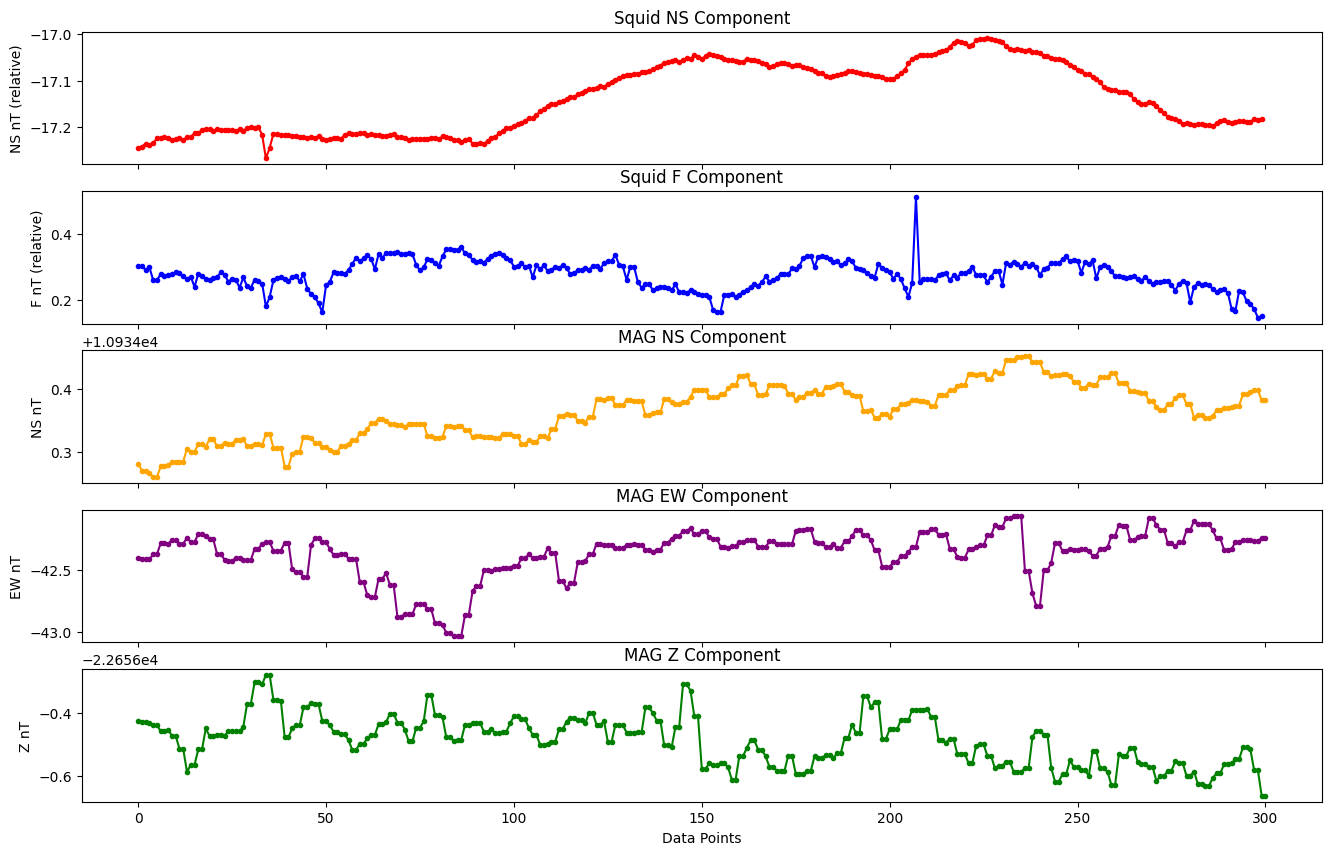

In [4]:
eda.generateDataPlots(df['NS_SQUID'].values, df['F_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 300, start_date, end_date)

Resampling? Something is wrong here

Resampled data frame head: 
                      NS_SQUID   F_SQUID  NS_Fluxgate  EW_Fluxgate   Z_Fluxgate
Time                                                                          
2024-03-21 15:15:10 -17.24030  0.297933  10934.27350    -42.41430 -22656.42710
2024-03-21 15:15:11 -17.22796  0.273600  10934.26738    -42.35048 -22656.44474
2024-03-21 15:15:12 -17.22518  0.278000  10934.28280    -42.28240 -22656.48548
2024-03-21 15:15:13 -17.21496  0.264180  10934.30582    -42.24788 -22656.54974
2024-03-21 15:15:14 -17.20542  0.268540  10934.31296    -42.30048 -22656.46686
This is the length 101
This is the time index for na records:
                      NS_SQUID  F_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
Time                                                                        
2024-03-21 15:16:00       NaN      NaN          NaN          NaN         NaN
2024-03-21 15:16:01       NaN      NaN          NaN          NaN         NaN
2024-03-21 15:16:02       NaN      NaN         

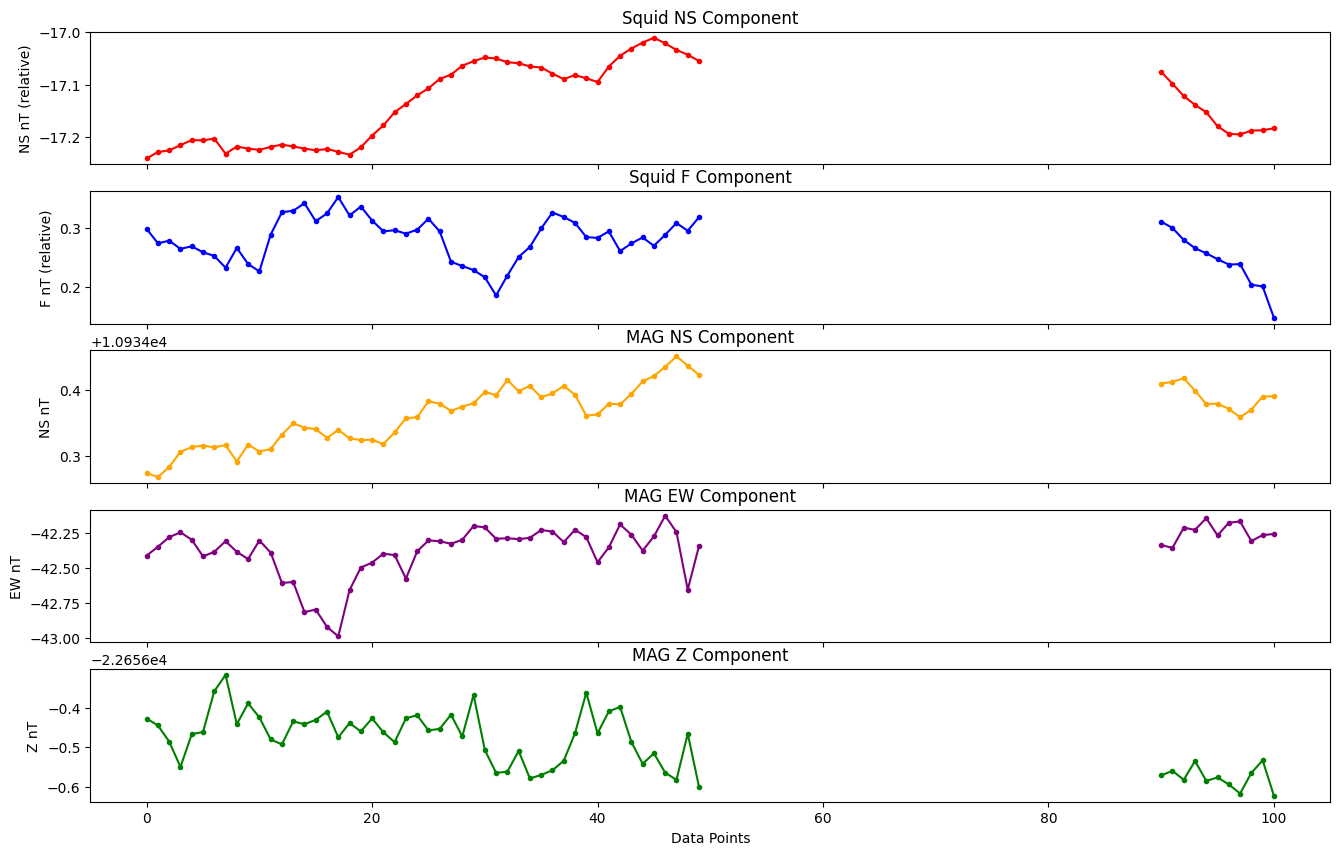

In [5]:
resampled_df = eda.resample_data(df, '1s')

# Print the length of the resampled dataframe
print(f'This is the length', len(resampled_df))
# Print the time index for the na records
print(f'This is the time index for na records:\n',resampled_df[resampled_df.isna().any(axis=1)])
# Print the number of na records
eda.generateDataPlots(resampled_df['NS_SQUID'].values, resampled_df['F_SQUID'].values, resampled_df['NS_Fluxgate'].values, resampled_df['EW_Fluxgate'].values, resampled_df['Z_Fluxgate'].values, resampled_df.shape[0], 300, start_date, end_date)

In [6]:
print(f'This is the number of na records:\n',resampled_df.isna().sum())
# Print the time index for the non-na records
# print(f'This is the time index for non-na records:\n',resampled_df[~resampled_df.isna().any(axis=1)].index)


This is the number of na records:
 NS_SQUID       40
F_SQUID        40
NS_Fluxgate    40
EW_Fluxgate    40
Z_Fluxgate     40
dtype: int64


Test for stationarity

In [7]:
df_results = {}
for column in df.columns:
    df_results[column] = eda.dickey_fuller_test(pd.Series(df[column]))

# Display the results
for column, result in df_results.items():
    print(f"Dickey-Fuller Test for {column}:")
    for key, value in result.items():
        print(f"{key}: {value}")
    print("\n")

Dickey-Fuller Test for NS_SQUID:
Test Statistic: nan
p-value: nan
Lags Used: 0
Number of Observations Used: 300
Critical Values: {'1%': -3.4523371197407404, '5%': -2.871222860740741, '10%': -2.571929211111111}
IC Best: nan


Dickey-Fuller Test for F_SQUID:
Test Statistic: nan
p-value: nan
Lags Used: 0
Number of Observations Used: 300
Critical Values: {'1%': -3.4523371197407404, '5%': -2.871222860740741, '10%': -2.571929211111111}
IC Best: nan


Dickey-Fuller Test for NS_Fluxgate:
Test Statistic: -2.2606238970249057
p-value: 0.1849820847776114
Lags Used: 8
Number of Observations Used: 292
Critical Values: {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}
IC Best: -2035.8141377534862


Dickey-Fuller Test for EW_Fluxgate:
Test Statistic: -2.1119286197542175
p-value: 0.23974517524184497
Lags Used: 12
Number of Observations Used: 288
Critical Values: {'1%': -3.453261605529366, '5%': -2.87162848654246, '10%': -2.5721455328896603}
IC Best: -850.1086225595177


D

Discontinuity Check

In [8]:
discontinuities, threshold, df_cleaned = eda.discontinuity_check(df,df_cntrl)
time_gaps, threshold = eda.discontinuity_check(df['NS_SQUID'])
print(f'The time gaps are: ',time_gaps[time_gaps> threshold])
eda.plot_cleaned_data(df_cleaned)


NullFrequencyError: Cannot shift with no freq

In [ ]:


eda.plot_cleaned_data(resampled_df)
# eda.plot_cleaned_data(df_cleaned)
# eda.write_data_summary(df, threshold, discontinuities)

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(resampled_df)
eda.plot_fourier_transform(fourier_results, components)